In [1]:
import os
import glob # <-- Импортируем библиотеку для поиска файлов
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

c:\Users\Tora\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SegmentationDatasetV2(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_filename = self.images[index]
        img_path = os.path.join(self.image_dir, img_filename)
        image = np.array(Image.open(img_path).convert("RGB"))
        
        base_name = os.path.splitext(img_filename)[0]
        
        mask_pattern = os.path.join(self.mask_dir, f"{base_name}-*.png")
        mask_paths = glob.glob(mask_pattern)
        
        combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

        if not mask_paths:
            print(f"Внимание: не найдено масок для изображения {img_filename}")
        else:
            for mask_path in mask_paths:
                individual_mask = np.array(Image.open(mask_path).convert("L"))
                combined_mask = np.logical_or(combined_mask, individual_mask)

        combined_mask = combined_mask.astype(np.float32)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=combined_mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            
        return image, mask

In [ ]:
train_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
])

IMAGE_DIR = "dataset/images/"
MASK_DIR = "dataset/masks/"

train_dataset = SegmentationDatasetV2(image_dir=IMAGE_DIR, mask_dir=MASK_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [4]:
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("--- Начинаем обучение модели U-Net ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    loop = tqdm(train_loader, leave=True)
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)
        
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    print(f"Эпоха {epoch+1}/{NUM_EPOCHS}, Средняя потеря: {running_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "unet_segmentation_model.pth")
print("--- Обучение завершено, модель сохранена! ---")

--- Начинаем обучение модели U-Net ---


100%|██████████| 17/17 [00:09<00:00,  1.84it/s, loss=0.374]


Эпоха 1/25, Средняя потеря: 0.4187


100%|██████████| 17/17 [00:03<00:00,  4.44it/s, loss=0.297]


Эпоха 2/25, Средняя потеря: 0.3314


100%|██████████| 17/17 [00:03<00:00,  4.28it/s, loss=0.24] 


Эпоха 3/25, Средняя потеря: 0.2747


100%|██████████| 17/17 [00:03<00:00,  4.40it/s, loss=0.217]


Эпоха 4/25, Средняя потеря: 0.2370


100%|██████████| 17/17 [00:03<00:00,  4.44it/s, loss=0.194]


Эпоха 5/25, Средняя потеря: 0.2176


100%|██████████| 17/17 [00:03<00:00,  4.47it/s, loss=0.23] 


Эпоха 6/25, Средняя потеря: 0.2048


100%|██████████| 17/17 [00:03<00:00,  4.44it/s, loss=0.176]


Эпоха 7/25, Средняя потеря: 0.1933


100%|██████████| 17/17 [00:04<00:00,  4.18it/s, loss=0.164]


Эпоха 8/25, Средняя потеря: 0.1822


100%|██████████| 17/17 [00:03<00:00,  4.39it/s, loss=0.171]


Эпоха 9/25, Средняя потеря: 0.1739


100%|██████████| 17/17 [00:03<00:00,  4.44it/s, loss=0.178]


Эпоха 10/25, Средняя потеря: 0.1683


100%|██████████| 17/17 [00:03<00:00,  4.40it/s, loss=0.141]


Эпоха 11/25, Средняя потеря: 0.1588


100%|██████████| 17/17 [00:03<00:00,  4.44it/s, loss=0.13] 


Эпоха 12/25, Средняя потеря: 0.1504


100%|██████████| 17/17 [00:03<00:00,  4.34it/s, loss=0.138]


Эпоха 13/25, Средняя потеря: 0.1422


100%|██████████| 17/17 [00:03<00:00,  4.46it/s, loss=0.179]


Эпоха 14/25, Средняя потеря: 0.1392


100%|██████████| 17/17 [00:03<00:00,  4.45it/s, loss=0.115]


Эпоха 15/25, Средняя потеря: 0.1312


100%|██████████| 17/17 [00:03<00:00,  4.48it/s, loss=0.127]


Эпоха 16/25, Средняя потеря: 0.1203


100%|██████████| 17/17 [00:04<00:00,  4.24it/s, loss=0.0921]


Эпоха 17/25, Средняя потеря: 0.1144


100%|██████████| 17/17 [00:03<00:00,  4.34it/s, loss=0.0937]


Эпоха 18/25, Средняя потеря: 0.1079


100%|██████████| 17/17 [00:03<00:00,  4.54it/s, loss=0.0902]


Эпоха 19/25, Средняя потеря: 0.1050


100%|██████████| 17/17 [00:03<00:00,  4.46it/s, loss=0.122] 


Эпоха 20/25, Средняя потеря: 0.0983


100%|██████████| 17/17 [00:03<00:00,  4.31it/s, loss=0.0925]


Эпоха 21/25, Средняя потеря: 0.0905


100%|██████████| 17/17 [00:03<00:00,  4.40it/s, loss=0.0901]


Эпоха 22/25, Средняя потеря: 0.0882


100%|██████████| 17/17 [00:03<00:00,  4.41it/s, loss=0.104] 


Эпоха 23/25, Средняя потеря: 0.0890


100%|██████████| 17/17 [00:03<00:00,  4.29it/s, loss=0.0871]


Эпоха 24/25, Средняя потеря: 0.0836


100%|██████████| 17/17 [00:03<00:00,  4.43it/s, loss=0.0781]

Эпоха 25/25, Средняя потеря: 0.0730
--- Обучение завершено, модель сохранена! ---


In [5]:
import matplotlib.pyplot as plt

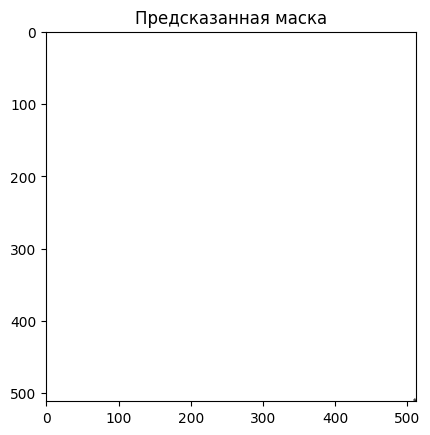

In [10]:
model.eval()

test_image_path = "augmented_data/26.png"
image = np.array(Image.open(test_image_path).convert("RGB"))

test_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(),
])
input_tensor = test_transform(image=image)["image"].unsqueeze(0).to(DEVICE)

with torch.no_grad():
    pred_mask = torch.sigmoid(model(input_tensor))
    pred_mask = (pred_mask > 0.5).float().cpu().numpy()

plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Предсказанная маска")
plt.show()